## Extreme imbalanced classification
https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098#:~:text=What%20is%20an%20extreme%20rare,%E2%80%9310%25%20of%20the%20total.

https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data.csv")

In [167]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [14]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [15]:
df

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,0,-0.877442,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,-0.080108,...,29.984624,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242
18394,0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,-0.080108,...,29.984624,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915699,0.010620,0.175348,-0.011235
18395,0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,-0.080108,...,29.984624,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228
18396,0,-0.822842,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,-0.080108,...,29.984624,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221


In [16]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)
df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)
df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [17]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [18]:
df_train_0_x_rescaled 

array([[ 0.8792632 , -0.07485305, -0.35278857, ...,  0.47210168,
         0.10901629, -0.78717868],
       [ 0.38280357, -1.02209172, -0.65458016, ...,  0.60548092,
         0.19014817,  1.11669686],
       [ 1.35131084,  0.6787562 , -0.03052621, ...,  0.49928568,
         0.12722336, -0.66035152],
       ...,
       [ 0.46613735, -0.10561612, -0.47637333, ...,  0.12686902,
         0.10811005,  0.05054944],
       [ 0.01270455, -0.81265379, -0.83577532, ...,  0.35665231,
         0.02811292,  1.343219  ],
       [ 1.01774414, -0.63344616, -1.27847064, ...,  0.40833496,
         0.12439426, -0.7194534 ]])

In [19]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 59)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1920      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
_________________________________________________________

In [20]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history


Train on 11697 samples, validate on 2926 samples
Epoch 1/200
11697/11697 [==============================] - 2s 139us/step - loss: 2.0922 - accuracy: 0.0412 - val_loss: 1.5692 - val_accuracy: 0.0424
Epoch 2/200
11697/11697 [==============================] - 1s 72us/step - loss: 1.1748 - accuracy: 0.0442 - val_loss: 0.9743 - val_accuracy: 0.0420
Epoch 3/200
11697/11697 [==============================] - 1s 94us/step - loss: 0.7962 - accuracy: 0.0603 - val_loss: 0.7725 - val_accuracy: 0.0786
Epoch 4/200
11697/11697 [==============================] - 1s 75us/step - loss: 0.6705 - accuracy: 0.1022 - val_loss: 0.6890 - val_accuracy: 0.1165
Epoch 5/200
11697/11697 [==============================] - 1s 63us/step - loss: 0.6048 - accuracy: 0.1189 - val_loss: 0.6249 - val_accuracy: 0.1347
Epoch 6/200
11697/11697 [==============================] - 1s 63us/step - loss: 0.5539 - accuracy: 0.1394 - val_loss: 0.5749 - val_accuracy: 0.1521
Epoch 7/200
11697/11697 [==============================] - 1s 

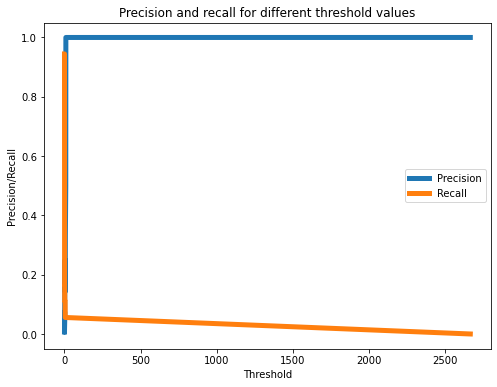

In [73]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

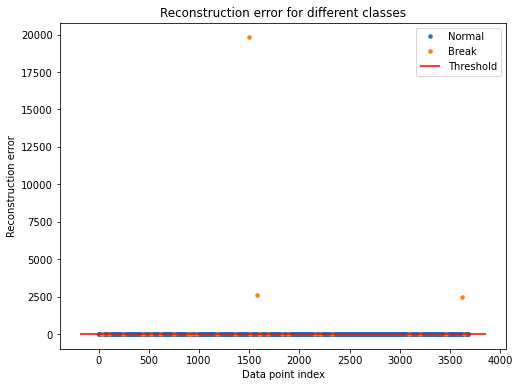

In [70]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [75]:
error_df[error_df.True_class==1].describe()

,Reconstruction_error,True_class
count,18.000000,18.0
mean,148.767662,1.0
std,628.713014,0.0
min,0.085590,1.0
25%,0.205549,1.0
50%,0.281215,1.0
75%,0.588441,1.0
max,2667.978882,1.0


In [76]:
error_df[error_df.True_class==0].describe()

,Reconstruction_error,True_class
count,2926.000000,2926.0
mean,0.197426,0.0
std,0.358434,0.0
min,0.026642,0.0
25%,0.100746,0.0
50%,0.138276,0.0
75%,0.202330,0.0
max,9.123017,0.0


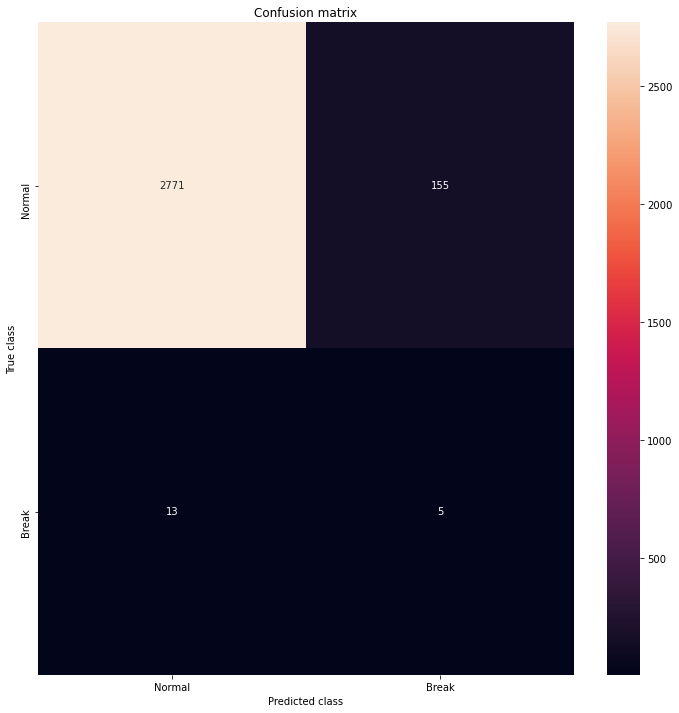

In [71]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

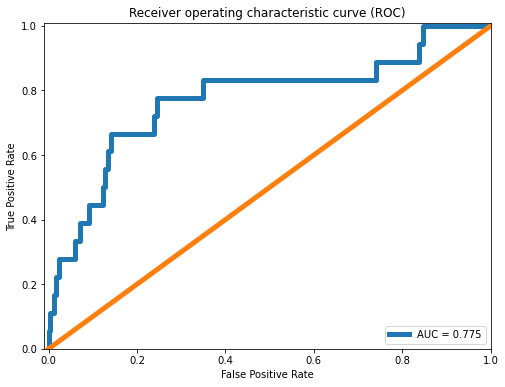

In [72]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()